In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/'

Mounted at /content/drive


# Specify each path

In [3]:
dataset = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/model/keypoint_classifier/keypoint.csv'
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 14

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 14)                154       
                                                                 
Total params: 1224 (4.78 KB)
Trainable params: 1224 (4.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [19]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
17/21 [=======================>......] - ETA: 0s - loss: 0.9959 - accuracy: 0.6494
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/model/keypoint_classifier/keypoint_classifier.hdf5
21/21 [==============================] - 0s 17ms/step - loss: 0.9925 - accuracy: 0.6466 - val_loss: 0.5935 - val_accuracy: 0.8079
Epoch 2/1000
17/21 [=======================>......] - ETA: 0s - loss: 0.9784 - accuracy: 0.6549
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/model/keypoint_classifier/keypoint_classifier.hdf5
21/21 [==============================] - 0s 7ms/step - loss: 0.9718 - accuracy: 0.6547 - val_loss: 0.5911 - val_accuracy: 0.8056
Epoch 3/1000
18/21 [========================>.....] - ETA: 0s - loss: 0.9827 - accuracy: 0.6415
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/model/keypoint_classifier/keypoint_classifier.hdf5
21/21 [==============================] - 0s 7ms/step - loss:

# Model evaluation

In [20]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

7/7 [==============================] - 0s 6ms/step - loss: 0.5724 - accuracy: 0.8079


# Loading the saved model

In [21]:
model = tf.keras.models.load_model(model_save_path)

In [22]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 117ms/step
[1.0967143e-05 2.0848960e-03 5.3368701e-04 1.7528387e-02 7.0298896e-08
 2.0671574e-05 4.8163041e-04 1.0672446e-04 6.2212849e-01 7.1464263e-02
 2.8546989e-01 2.3284835e-08 1.6985732e-04 5.2586529e-07]
8


# Confusion matrix

27/27 [==============================] - 0s 2ms/step


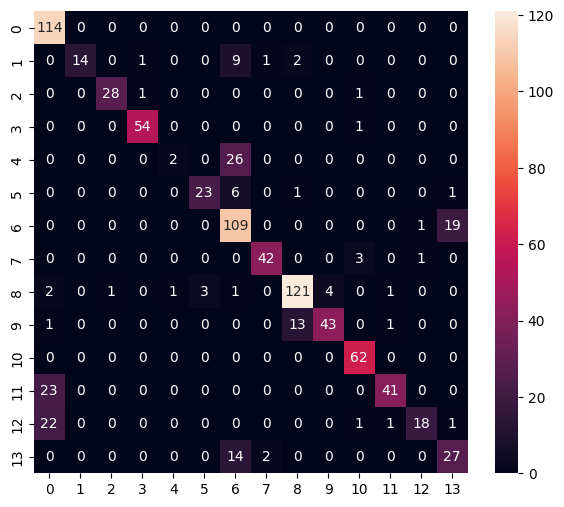

Classification Report
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       114
           1       1.00      0.52      0.68        27
           2       0.97      0.93      0.95        30
           3       0.96      0.98      0.97        55
           4       0.67      0.07      0.13        28
           5       0.88      0.74      0.81        31
           6       0.66      0.84      0.74       129
           7       0.93      0.91      0.92        46
           8       0.88      0.90      0.89       134
           9       0.91      0.74      0.82        58
          10       0.91      1.00      0.95        62
          11       0.93      0.64      0.76        64
          12       0.90      0.42      0.57        43
          13       0.56      0.63      0.59        43

    accuracy                           0.81       864
   macro avg       0.85      0.74      0.76       864
weighted avg       0.83      0.81      0.79       864



In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [24]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6984

# Inference test

In [26]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [27]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [28]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [29]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 289 µs, sys: 850 µs, total: 1.14 ms
Wall time: 1.28 ms


In [30]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0967131e-05 2.0848948e-03 5.3368619e-04 1.7528361e-02 7.0298761e-08
 2.0671554e-05 4.8163041e-04 1.0672456e-04 6.2212849e-01 7.1464308e-02
 2.8546983e-01 2.3284793e-08 1.6985730e-04 5.2586631e-07]
8
